<a href="https://colab.research.google.com/github/cnn22/SingerSongwriter/blob/main/RNN_Emotions_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [86]:
#Read in data
train = pd.read_csv('/train.txt', ';', header=None, names=['Sentence', 'Emotion'], index_col=False)
test = pd.read_csv('/test.txt', ';', header=None, names=['Sentence', 'Emotion'], index_col=False)

In [89]:
test.Emotion.unique()

array([0, 5, 4, 1, 2, 3], dtype=object)

In [87]:
train.loc[train.Emotion == 'sadness', 'Emotion'] = 0
train.loc[train.Emotion == 'anger', 'Emotion'] = 1
train.loc[train.Emotion == 'love', 'Emotion'] = 2
train.loc[train.Emotion == 'surprise', 'Emotion'] = 3
train.loc[train.Emotion == 'fear', 'Emotion'] = 4
train.loc[train.Emotion == 'joy', 'Emotion'] = 5

In [88]:
test.loc[test.Emotion == 'sadness', 'Emotion'] = 0
test.loc[test.Emotion == 'anger', 'Emotion'] = 1
test.loc[test.Emotion == 'love', 'Emotion'] = 2
test.loc[test.Emotion == 'surprise', 'Emotion'] = 3
test.loc[test.Emotion == 'fear', 'Emotion'] = 4
test.loc[test.Emotion == 'joy', 'Emotion'] = 5

In [94]:
train.Emotion = train.Emotion.astype('int64')
test.Emotion = test.Emotion.astype('int64')

In [97]:
#converting pandas df into a 'TensorSliceDataset' type so we can use tensor flow objects...

train = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train['Sentence'].values, tf.string),
            tf.cast(train['Emotion'].values, tf.int64)
        )
    )
)

test = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test['Sentence'].values, tf.string),
            tf.cast(test['Emotion'].values, tf.int64)
        )
    )
)

In [98]:
#Shuffle the train and test data sets
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test = test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [99]:
for example, label in train.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'i know im quite selfish but sometimes i feel like i dont want to throw everything just for something that is uncertain'
 b'i suck a lot at keeping the house clean and yet feel twitchy when its messy'
 b'im feeling shaky and feverish and mad']

labels:  [4 0 4]


# Encode Text


In [100]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)

encoder.adapt(train.map(lambda text, label: text))

In [101]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'feel', 'and', 'to', 'the', 'a', 'that',
       'feeling', 'of', 'my', 'in', 'it', 'like', 'so', 'for', 'im', 'me',
       'but'], dtype='<U13')

# Creating the Model

In [102]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [103]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train the Model

In [104]:
history = model.fit(train, epochs=10,
                    validation_data=test,
                    validation_steps=30)

Epoch 1/10
250/250 [==============================] - 38s 122ms/step - loss: -13.5638 - accuracy: 0.1851 - val_loss: -41.0301 - val_accuracy: 0.1370
Epoch 2/10
250/250 [==============================] - 28s 110ms/step - loss: -68.1253 - accuracy: 0.1349 - val_loss: -97.3083 - val_accuracy: 0.1370
Epoch 3/10
250/250 [==============================] - 27s 109ms/step - loss: -125.1188 - accuracy: 0.1349 - val_loss: -158.4431 - val_accuracy: 0.1370
Epoch 4/10
250/250 [==============================] - 28s 112ms/step - loss: -189.7120 - accuracy: 0.1349 - val_loss: -228.7596 - val_accuracy: 0.1370
Epoch 5/10
250/250 [==============================] - 28s 112ms/step - loss: -264.0112 - accuracy: 0.1349 - val_loss: -309.3284 - val_accuracy: 0.1370
Epoch 6/10
250/250 [==============================] - 28s 111ms/step - loss: -348.5019 - accuracy: 0.1349 - val_loss: -400.4478 - val_accuracy: 0.1370
Epoch 7/10
250/250 [==============================] - 28s 110ms/step - loss: -443.5012 - accuracy:

In [106]:
test_loss, test_acc = model.evaluate(test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

32/32 [==============================] - 1s 29ms/step - loss: -866.0884 - accuracy: 0.1375
Test Loss: -866.08837890625
Test Accuracy: 0.13750000298023224


(0.0, 29.291205644607544)

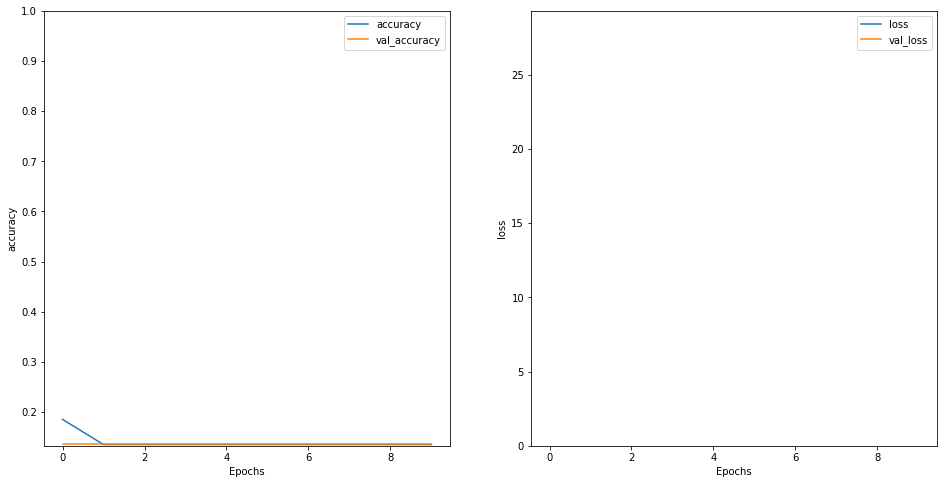

In [113]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


# 😅
# improve this model...please


